#### Lab04 
## Forecasting Several Time Steps Ahead
- RNN으로 여러개를 예측하기 (loop_forward)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import myplot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model


In [2]:
def generate_time_series(batch_size, n_steps):        
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    
    time = np.linspace(0, 1, n_steps)    
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2    
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise    
    return series[..., np.newaxis].astype(np.float32)

In [3]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [4]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(1000, n_steps + 10)
X_train = series[:700, :n_steps]
X_valid = series[700:900, :n_steps]
X_test = series[900:, :n_steps]
Y = np.empty((1000, n_steps, 10))

for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
    
Y_train = Y[:700]
Y_valid = Y[700:900]
Y_test = Y[900:]

## WaveNet

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()

model.add(keras.layers.InputLayer(input_shape=[None, 1]))

for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
    
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))


model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          60        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 20)          8

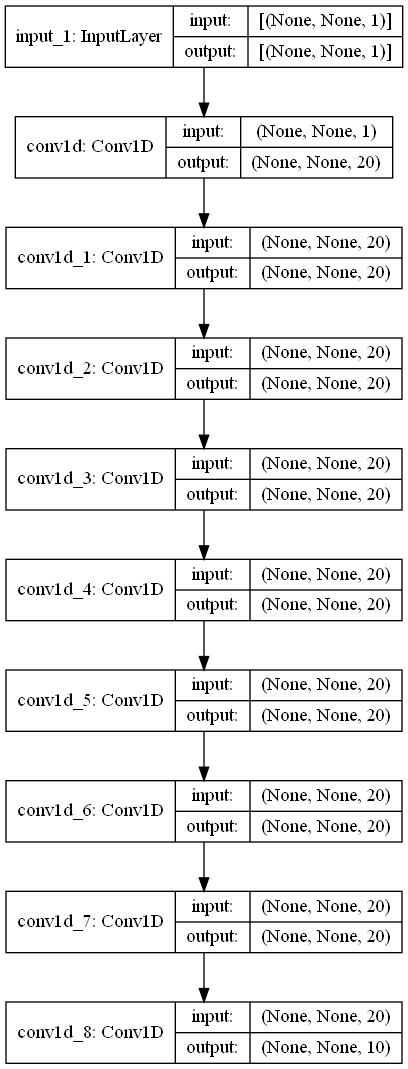

In [6]:
model.summary()
plot_model(model, to_file='./b6_model_GRU_TimeD.png', show_shapes=True)

In [7]:
%%time
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
22/22 [==============================] - 8s 307ms/step - loss: 0.1424 - last_time_step_mse: 0.1374 - val_loss: 0.1333 - val_last_time_step_mse: 0.1380
Epoch 2/20
22/22 [==============================] - 6s 291ms/step - loss: 0.1152 - last_time_step_mse: 0.1068 - val_loss: 0.0968 - val_last_time_step_mse: 0.0915
Epoch 3/20
22/22 [==============================] - 6s 293ms/step - loss: 0.0849 - last_time_step_mse: 0.0701 - val_loss: 0.0714 - val_last_time_step_mse: 0.0601
Epoch 4/20
22/22 [==============================] - 7s 304ms/step - loss: 0.0670 - last_time_step_mse: 0.0493 - val_loss: 0.0597 - val_last_time_step_mse: 0.0462
Epoch 5/20
22/22 [==============================] - 6s 289ms/step - loss: 0.0579 - last_time_step_mse: 0.0398 - val_loss: 0.0545 - val_last_time_step_mse: 0.0415
Epoch 6/20
22/22 [==============================] - 6s 292ms/step - loss: 0.0515 - last_time_step_mse: 0.0343 - val_loss: 0.0470 - val_last_time_step_mse: 0.0310
Epoch 7/20
22/22 [==========

In [8]:
model.evaluate(X_valid, Y_valid)

7/7 [==============================] - 0s 5ms/step - loss: 0.0293 - last_time_step_mse: 0.0148


[0.029316801577806473, 0.014804738573729992]

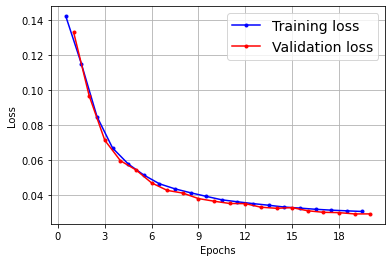

In [9]:
myplot.plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [10]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

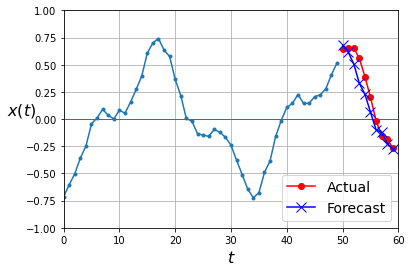

In [11]:
myplot.plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [12]:
b8 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of WaveNet :', b8)

The loss of WaveNet : 0.030697358772158623


## WaveNet-2 with Gated Activation Units 

- Here is the original WaveNet defined in the paper: 
- it uses Gated Activation Units instead of ReLU and parametrized skip connections, 
- plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [13]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [14]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [15]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [16]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [17]:
%%time 
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
22/22 [==============================] - 9s 330ms/step - loss: 0.1535 - last_time_step_mse: 0.1460 - val_loss: 0.1495 - val_last_time_step_mse: 0.1547
Epoch 2/20
22/22 [==============================] - 7s 313ms/step - loss: 0.1428 - last_time_step_mse: 0.1350 - val_loss: 0.1358 - val_last_time_step_mse: 0.1416
Epoch 3/20
22/22 [==============================] - 6s 268ms/step - loss: 0.1320 - last_time_step_mse: 0.1253 - val_loss: 0.1300 - val_last_time_step_mse: 0.1333
Epoch 4/20
22/22 [==============================] - 5s 222ms/step - loss: 0.1286 - last_time_step_mse: 0.1215 - val_loss: 0.1283 - val_last_time_step_mse: 0.1314
Epoch 5/20
22/22 [==============================] - 1s 28ms/step - loss: 0.1274 - last_time_step_mse: 0.1205 - val_loss: 0.1275 - val_last_time_step_mse: 0.1304
Epoch 6/20
22/22 [==============================] - 1s 25ms/step - loss: 0.1265 - last_time_step_mse: 0.1197 - val_loss: 0.1264 - val_last_time_step_mse: 0.1294
Epoch 7/20
22/22 [============

In [18]:
model.evaluate(X_valid, Y_valid)

7/7 [==============================] - 0s 7ms/step - loss: 0.1230 - last_time_step_mse: 0.1257


[0.1230483427643776, 0.125667005777359]

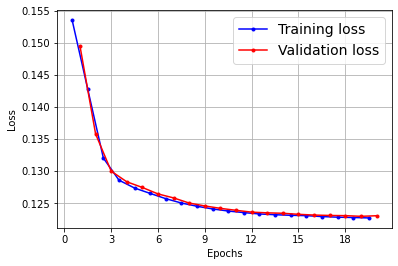

In [19]:
myplot.plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [20]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

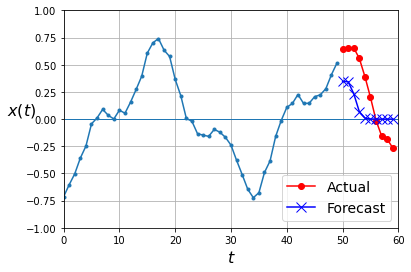

In [21]:
myplot.plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [22]:
b9 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of ORIG_WaveNet :', b9)

The loss of ORIG_WaveNet : 0.12270890176296234


# Results Summary

In [23]:
models = pd.DataFrame({
    'Model': ['WaveNet+LF', 'WaveNet_LF_ORIG'],
    'Score': [b8,b9 ]})
models.sort_values(by='Score', ascending=True)

Model     Score
0       WaveNet+LF  0.030697
1  WaveNet_LF_ORIG  0.122709